In [24]:
import numpy as np
import pandas as pd

## Data Handling

In [25]:
#Import csv file from data folder
PriceData = pd.read_csv('../Data/Price.csv')

#Filter all rows that do not equal DE for the column Country
PriceData = PriceData[PriceData['PriceArea'] == 'DE']

#Drop the column PriceDKK
PriceData = PriceData.drop(columns=['PriceDKK'])
#Rename hour DK to Date
PriceData = PriceData.rename(columns={'HourDK': 'Date'})

array([[<Axes: title={'center': 'PriceEUR'}>]], dtype=object)

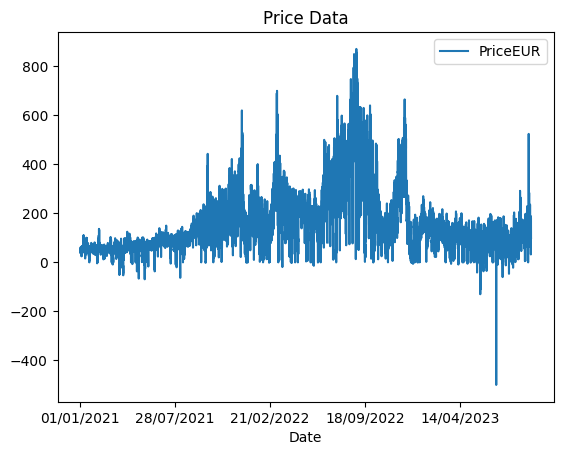

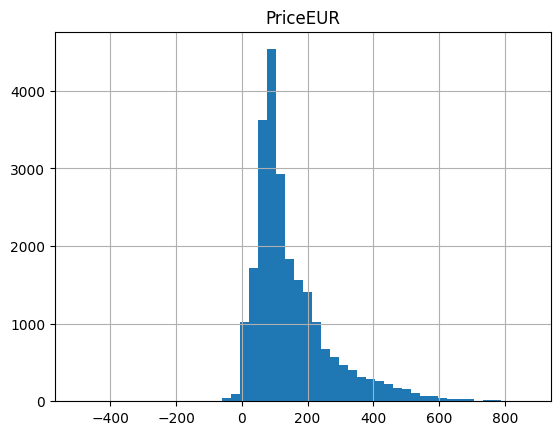

In [26]:
#Plot the price data
PriceData.plot(x='Date', y='PriceEUR', kind='line', title='Price Data')

#Plot the distribution of prices
PriceData.hist(column='PriceEUR', bins=50)


In [27]:

def categorize_prices(df, price_column="PriceEUR"):
    """
    Categorize prices in a DataFrame column into four categories:
    - Negative Prices
    - Low Prices (bottom 33% of non-negative prices)
    - Medium Prices (middle 33% of non-negative prices)
    - High Prices (top 33% of non-negative prices)

    Args:
    - df: Input DataFrame with a column of prices.
    - price_column: Name of the column containing price data (default is "PriceEUR").

    Returns:
    - DataFrame with an additional "Category" column for the price categories.
    """
    # Ensure the column exists
    if price_column not in df.columns:
        raise ValueError(f"Column '{price_column}' not found in the DataFrame.")

    # Extract the price column
    prices = df[price_column]

    # Separate negative prices
    negative_mask = prices < 0
    negative_prices = prices[negative_mask]

    # Non-negative prices
    non_negative_prices = prices[~negative_mask]

    # Calculate quantiles for non-negative prices
    low_threshold = non_negative_prices.quantile(0.33)
    medium_threshold = non_negative_prices.quantile(0.67)

    # Categorize prices
    categories = []
    for price in prices:
        if price < 0:
            categories.append("Negative")
        elif price <= low_threshold:
            categories.append("Low")
        elif price <= medium_threshold:
            categories.append("Medium")
        else:
            categories.append("High")

    # Add the categories as a new column to the DataFrame
    df["Category"] = categories

    return df






In [28]:
# Categorize the prices
Categorized_PriceData = categorize_prices(PriceData)

In [29]:
def calculate_transition_matrix(df, category_column="Category"):
    """
    Calculate the transition probability matrix for categories.

    Args:
    - df: DataFrame with a sequential column of categories.
    - category_column: Name of the column containing the categories.

    Returns:
    - 4x4 transition probability matrix as a DataFrame.
    """
    # Ensure the column exists
    if category_column not in df.columns:
        raise ValueError(f"Column '{category_column}' not found in the DataFrame.")

    # Extract categories from input df

    categories = df[category_column].unique()
    transitions = df[category_column].values

    # Initialize a 4x4 matrix for counts
    transition_counts = pd.DataFrame(
        np.zeros((len(categories), len(categories))),
        index=categories,
        columns=categories,
    )

    # Count transitions
    for i in range(len(transitions) - 1):
        current_category = transitions[i]
        next_category = transitions[i + 1]
        if current_category in categories and next_category in categories:
            transition_counts.loc[current_category, next_category] += 1

    # Normalize rows to get probabilities
    transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0).fillna(0)

    return transition_matrix






In [30]:
# Calculate transition probabilities
transition_matrix = calculate_transition_matrix(Categorized_PriceData).to_dict()


In [31]:


class BatteryOptimization:
    def __init__(self, states, actions, price_df, transition_prob, gamma=0.9, epsilon=0.01):
        """
        Initialize the Battery Optimization problem.
        
        Args:
        - states: List of all possible states (SOC, PriceCategory).
        - actions: List of possible actions (e.g., ["Charge", "Discharge", "Nothing"]).
        - price_df: DataFrame with columns ['PriceValue', 'PriceCategory'].
        - transition_prob: Dictionary with transition probabilities between price categories.
        - gamma: Discount factor (default 0.9).
        - epsilon: Convergence threshold for value iteration (default 0.01).
        """
        self.states = states
        self.actions = actions
        self.price_df = price_df.set_index("Category")  # Easier access by category
        self.transition_prob = transition_prob
        self.gamma = gamma
        self.epsilon = epsilon
        self.value_function = np.zeros(len(states))  # Initialize V(s) = 0 for all states
        self.policy = ["Nothing"] * len(states)  # Initialize policy

    def is_valid_action(self, soc, action):
        """Checks if an action is valid for a given SOC."""
        if action == "Discharge" and soc == 0:
            return False  # Cannot discharge at SOC = 0
        if action == "Charge" and soc == 500:
            return False  # Cannot charge at SOC = 500
        return True

    def get_next_state(self, soc, action):
        """Calculates the next SOC based on the action."""
        if action == "Charge" and soc < 500:
            return soc + 100
        elif action == "Discharge" and soc > 0:
            return soc - 100
        return soc  # "Nothing" or out-of-bound action

    def reward(self, action, price_category):
        price_value = self.price_df.loc[price_category, "PriceEUR"]
        if isinstance(price_value, pd.Series):
            price_value = price_value.iloc[0]  # Use the first value
        if action == "Charge":
            return -100 * price_value
        elif action == "Discharge":
            return 100 * price_value
        return 0

    def value_iteration(self):
        while True:
            delta = 0
            new_value_function = np.zeros(len(self.states))

            for s, (soc, price_category) in enumerate(self.states):
                action_values = []

                for action in self.actions:
                    if not self.is_valid_action(soc, action):
                        continue  # Skip invalid actions

                    # Calculate next SOC
                    next_soc = self.get_next_state(soc, action)
                    expected_value = 0

                    # Compute expected value for transitioning to next states
                    for next_price_category, prob in self.transition_prob[price_category].items():
                        next_state = (next_soc, next_price_category)
                        if next_state in self.states:
                            next_state_index = self.states.index(next_state)
                            reward = self.reward(action, price_category)
                            expected_value += prob * (reward + self.gamma * self.value_function[next_state_index])

                    action_values.append(expected_value)

                # Update the value for this state
                if action_values:
                    new_value_function[s] = max(action_values)
                else:
                    new_value_function[s] = self.value_function[s]

                delta = max(delta, abs(new_value_function[s] - self.value_function[s]))

            self.value_function = new_value_function
            if delta < self.epsilon:
                break

    def extract_policy(self):
        for s, (soc, price_category) in enumerate(self.states):
            action_values = []

            for action in self.actions:
                if not self.is_valid_action(soc, action):
                    continue  # Skip invalid actions

                # Calculate next SOC
                next_soc = self.get_next_state(soc, action)
                expected_value = 0

                # Compute expected value for transitioning to next states
                for next_price_category, prob in self.transition_prob[price_category].items():
                    next_state = (next_soc, next_price_category)
                    if next_state in self.states:
                        next_state_index = self.states.index(next_state)
                        reward = self.reward(action, price_category)
                        expected_value += prob * (reward + self.gamma * self.value_function[next_state_index])

                action_values.append((expected_value, action))

            # Select action with the highest value
            if action_values:
                _, best_action = max(action_values)
                self.policy[s] = best_action
            else:
                self.policy[s] = "Nothing"  # Default if no valid actions

    def solve(self):
        """Runs value iteration and extracts the optimal policy."""
        self.value_iteration()
        self.extract_policy()




In [32]:

class BatteryValueIteration:
    def __init__(self, soc_levels, actions, price_series, price_categories, transition_matrix, gamma=0.9, epsilon=0.01):
        """
        Initialize the Battery Value Iteration problem.
        
        Args:
        - soc_levels: List of SOC levels (e.g., [0, 100, 200, ..., 500]).
        - actions: List of actions (e.g., ["Charge", "Discharge", "Nothing"]).
        - price_series: DataFrame with columns ['Hour', 'Category', 'Price'].
        - price_categories: List of unique price categories (e.g., ["Negative", "Low", "Medium", "High"]).
        - transition_matrix: Transition probability matrix (dict of dicts).
        - gamma: Discount factor (default 0.9).
        - epsilon: Convergence threshold for value iteration (default 0.01).
        """
        self.soc_levels = soc_levels
        self.actions = actions
        self.price_series = price_series
        self.price_categories = price_categories
        self.transition_matrix = transition_matrix
        self.gamma = gamma
        self.epsilon = epsilon
        
        # Define all possible states as (SOC, PriceCategory)
        self.states = [(soc, category) for soc in soc_levels for category in price_categories]
        
        # Initialize value function and policy
        self.value_function = {state: 0 for state in self.states}
        self.policy = {state: "Nothing" for state in self.states}

    def is_valid_action(self, soc, action):
        """Check if the action is valid given the SOC."""
        if action == "Discharge" and soc == 0:
            return False  # Cannot discharge if SOC is 0
        if action == "Charge" and soc == max(self.soc_levels):
            return False  # Cannot charge if SOC is at its maximum
        return True



    def get_next_soc(self, soc, action):
        """Determine the next SOC based on the action."""
        if action == "Charge":
            return min(soc + 100, max(self.soc_levels))
        elif action == "Discharge":
            return max(soc - 100, 0)
        return soc

    def reward(self, action, price):
        """Calculate the reward for a given action and price."""
        if action == "Charge":
            return -100 * price  # Cost of charging
        elif action == "Discharge":
            return 100 * price  # Revenue from discharging
        return 0  # No cost/reward for doing nothing

    def value_iteration(self):
        """Perform the value iteration algorithm."""
        while True:
            delta = 0  # Track convergence
            new_value_function = self.value_function.copy()

            for state in self.states:
                soc, price_category = state
                action_values = []

                for action in self.actions:
                    # Enforce validity check
                    if not self.is_valid_action(soc, action):
                        continue

                    next_soc = self.get_next_soc(soc, action)
                    expected_value = 0

                    for next_category, prob in self.transition_matrix[price_category].items():
                        next_state = (next_soc, next_category)
                        if next_state in self.states:
                            reward = self.reward(action, self.price_series[self.price_series["Category"] == next_category]["PriceEUR"])
                            expected_value += prob * (reward + self.gamma * self.value_function[next_state])

                    action_values.append(expected_value)

            # Debugging: Print state and valid actions
            print(f"State: {state}, Valid Actions: {action_values}")

            # Update the value function and policy only if valid actions exist
            if action_values:
                best_action_index = np.argmax(action_values)
                new_value_function[state] = action_values[best_action_index]
                self.policy[state] = self.actions[best_action_index]
            else:
                # No valid actions; set default values
                new_value_function[state] = self.value_function[state]
                self.policy[state] = "Nothing"

            delta = max(delta, abs(new_value_function[state] - self.value_function[state]))

        self.value_function = new_value_function
        if delta < self.epsilon:
            break


                # Update the value function and policy only if valid actions exist
                if action_values:
                    new_value_function[state] = max(action_values)
                    best_action = self.actions[np.argmax(action_values)]
                    self.policy[state] = best_action
                else:
                    new_value_function[state] = self.value_function[state]
                    self.policy[state] = "Nothing"  # Default to "Nothing" if no valid actions

                delta = max(delta, abs(new_value_function[state] - self.value_function[state]))

            self.value_function = new_value_function
            if delta < self.epsilon:
                break


    def get_policy(self):
        """Return the computed policy."""
        return self.policy

    def get_value_function(self):
        """Return the computed value function."""
        return self.value_function


IndentationError: unexpected indent (4216518288.py, line 103)

In [33]:


class BatteryValueIteration:
    def __init__(self, soc_levels, actions, price_series, price_categories, transition_matrix, gamma=0.9, epsilon=0.01):
        """
        Initialize the Battery Value Iteration problem.
        
        Args:
        - soc_levels: List of SOC levels (e.g., [0, 100, 200, ..., 500]).
        - actions: List of actions (e.g., ["Charge", "Discharge", "Nothing"]).
        - price_series: DataFrame with columns ['Hour', 'Category', 'Price'].
        - price_categories: List of unique price categories (e.g., ["Negative", "Low", "Medium", "High"]).
        - transition_matrix: Transition probability matrix (dict of dicts).
        - gamma: Discount factor (default 0.9).
        - epsilon: Convergence threshold for value iteration (default 0.01).
        """
        self.soc_levels = soc_levels
        self.actions = actions
        self.price_series = price_series
        self.price_categories = price_categories
        self.transition_matrix = transition_matrix
        self.gamma = gamma
        self.epsilon = epsilon
        
        # Define all possible states as (SOC, PriceCategory)
        self.states = [(soc, category) for soc in soc_levels for category in price_categories]
        
        # Initialize value function and policy
        self.value_function = {state: 0 for state in self.states}
        self.policy = {state: "Nothing" for state in self.states}

    def is_valid_action(self, soc, action):
        """Check if the action is valid given the SOC."""
        valid = not (
            (action == "Discharge" and soc == 0) or
            (action == "Charge" and soc == max(self.soc_levels))
        )
        print(f"Action: {action}, SOC: {soc}, Valid: {valid}")  # Debugging action validity
        return valid

    def get_next_soc(self, soc, action):
        """Determine the next SOC based on the action."""
        if action == "Charge":
            return min(soc + 100, max(self.soc_levels))
        elif action == "Discharge":
            return max(soc - 100, 0)
        return soc

    def reward(self, action, price):
        """Calculate the reward for a given action and price."""
        if action == "Charge":
            return -100 * price  # Cost of charging
        elif action == "Discharge":
            return 100 * price  # Revenue from discharging
        return 0  # No cost/reward for doing nothing

    def value_iteration(self):
        """Perform the value iteration algorithm."""
        while True:
            delta = 0  # Track convergence
            new_value_function = self.value_function.copy()

            for state in self.states:
                soc, price_category = state
                action_values = []

                for action in self.actions:
                    # Enforce validity check
                    if not self.is_valid_action(soc, action):
                        continue

                    next_soc = self.get_next_soc(soc, action)
                    expected_value = 0

                    for next_category, prob in self.transition_matrix[price_category].items():
                        next_state = (next_soc, next_category)
                        if next_state in self.states:
                            reward = self.reward(
                                action,
                                self.price_series[self.price_series["Category"] == next_category]["PriceEUR"].mean(),
                            )
                            expected_value += prob * (reward + self.gamma * self.value_function[next_state])

                    action_values.append(expected_value)

                # Debugging: Print state and valid actions
                print(f"State: {state}, Valid Actions: {action_values}")

                # Update the value function and policy only if valid actions exist
                if action_values:
                    best_action_index = np.argmax(action_values)
                    new_value_function[state] = action_values[best_action_index]
                    self.policy[state] = self.actions[best_action_index]
                else:
                    # No valid actions; set default values
                    new_value_function[state] = self.value_function[state]
                    self.policy[state] = "Nothing"

                delta = max(delta, abs(new_value_function[state] - self.value_function[state]))

            self.value_function = new_value_function
            if delta < self.epsilon:
                break

    def get_policy(self):
        """Return the computed policy."""
        return self.policy

    def get_value_function(self):
        """Return the computed value function."""
        return self.value_function


In [34]:


# SOC levels and actions
soc_levels = [0, 100, 200, 300, 400, 500]
actions = ["Charge", "Discharge", "Nothing"]
price_categories = Categorized_PriceData["Category"].unique()

# Initialize and run value iteration
optimizer = BatteryValueIteration(soc_levels, actions, Categorized_PriceData, price_categories, transition_matrix)
optimizer.value_iteration()

# Print results
# print("Value Function:")
# for state, value in optimizer.get_value_function().items():
#     print(f"State: {state}, Value: {value:.2f}")




Action: Charge, SOC: 0, Valid: True
Action: Discharge, SOC: 0, Valid: False
Action: Nothing, SOC: 0, Valid: True
State: (0, 'Low'), Valid Actions: [-5626.830877688088, 0.0]
Action: Charge, SOC: 0, Valid: True
Action: Discharge, SOC: 0, Valid: False
Action: Nothing, SOC: 0, Valid: True
State: (0, 'Medium'), Valid Actions: [-12169.14976389462, 0.0]
Action: Charge, SOC: 0, Valid: True
Action: Discharge, SOC: 0, Valid: False
Action: Nothing, SOC: 0, Valid: True
State: (0, 'Negative'), Valid Actions: [1272.4340194470162, 0.0]
Action: Charge, SOC: 0, Valid: True
Action: Discharge, SOC: 0, Valid: False
Action: Nothing, SOC: 0, Valid: True
State: (0, 'High'), Valid Actions: [-27405.025452337373, 0.0]
Action: Charge, SOC: 100, Valid: True
Action: Discharge, SOC: 100, Valid: True
Action: Nothing, SOC: 100, Valid: True
State: (100, 'Low'), Valid Actions: [-5626.830877688088, 5626.830877688088, 0.0]
Action: Charge, SOC: 100, Valid: True
Action: Discharge, SOC: 100, Valid: True
Action: Nothing, SOC

In [35]:
print("\nPolicy:")
for state, action in optimizer.get_policy().items():
    print(f"State: {state}, Policy: {action}")


Policy:
State: (0, 'Low'), Policy: Discharge
State: (0, 'Medium'), Policy: Discharge
State: (0, 'Negative'), Policy: Charge
State: (0, 'High'), Policy: Discharge
State: (100, 'Low'), Policy: Discharge
State: (100, 'Medium'), Policy: Discharge
State: (100, 'Negative'), Policy: Charge
State: (100, 'High'), Policy: Discharge
State: (200, 'Low'), Policy: Discharge
State: (200, 'Medium'), Policy: Discharge
State: (200, 'Negative'), Policy: Charge
State: (200, 'High'), Policy: Discharge
State: (300, 'Low'), Policy: Discharge
State: (300, 'Medium'), Policy: Discharge
State: (300, 'Negative'), Policy: Charge
State: (300, 'High'), Policy: Discharge
State: (400, 'Low'), Policy: Discharge
State: (400, 'Medium'), Policy: Discharge
State: (400, 'Negative'), Policy: Charge
State: (400, 'High'), Policy: Discharge
State: (500, 'Low'), Policy: Charge
State: (500, 'Medium'), Policy: Charge
State: (500, 'Negative'), Policy: Discharge
State: (500, 'High'), Policy: Charge
